# Network Traffic Recognition Model

## Project Overview
This notebook is part of a larger project on network traffic analysis at Ariel University. It focuses on classifying different types of network traffic based on their characteristic network patterns, even when the traffic is encrypted. By identifying traffic types without inspecting payload content, we can develop tools for network optimization and security monitoring while preserving user privacy.

## Problem Statement
Modern internet traffic is predominantly encrypted, making traditional deep packet inspection techniques ineffective for traffic classification. However, despite encryption, traffic still contains patterns and metadata that can reveal the underlying application. This notebook demonstrates how machine learning models can effectively identify application types solely from observable network traffic patterns without decrypting the content.

## Dataset Description
The `HTTPS-clf-dataset.csv` contains network flow features extracted from various applications' traffic captures. This dataset was specifically designed for encrypted traffic classification research and is available on [Kaggle](https://www.kaggle.com/datasets/inhngcn/https-traffic-classification/data).

Our target variable is the `TYPE` column, which categorizes network traffic into six distinct classes:
- `L` - Live Video Streaming
- `P` - Video Player
- `M` - Music Player
- `U` - File Upload
- `D` - File Download
- `W` - Website and other traffic

The dataset includes numerous features that characterize network flows without revealing content:
- Packet size statistics (mean, variance, max, min)
- Timing information (inter-arrival times)
- Flow duration and throughput metrics
- Burst analysis (number of bursts, bytes per burst, burst duration)
- Traffic direction metrics (upstream vs. downstream)

These features preserve user privacy (no content is inspected) while still containing distinctive patterns that characterize different applications. The patterns emerge from the inherent requirements of each application type - for example, video streaming requires different packet timing and sizes than file downloads or web browsing.

## Methodology
Our approach involves:
1. **Data Preprocessing**: Cleaning the dataset, handling missing values, and normalizing features
2. **Exploratory Data Analysis**: Understanding feature distributions and correlations
3. **Feature Selection**: Identifying the most discriminative features
4. **Model Training**: Implementing and optimizing multiple classification models (Random Forest, XGBoost, Neural Networks)
5. **Performance Evaluation**: Comparing models using cross-validation and various metrics
6. **Interpretation**: Analyzing feature importance to understand what makes different applications distinguishable

This notebook demonstrates that encrypted traffic analysis can accurately identify application types, with important implications for network management, security monitoring, and privacy research. Understanding these classification techniques is crucial for both network optimization and for developing more privacy-preserving communication methods.

# Notice 🚨

Some of the cells in this notebook are commented out due to their long runtime ⏳. If you want to see the complete calculations, you will need to uncomment these cells and run them.

To uncomment a cell, simply remove the `#` or `"""` symbols at the beginning and end of the cell.

Please be aware that uncommenting and running these cells may take a significant amount of time, depending on the complexity of the calculations and the performance of your system 🖥️.

## Load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_SEED=42

In [2]:
df = pd.read_csv("/kaggle/input/https-traffic-classification/HTTPS-clf-dataset.csv", index_col=0)

df

,BYTES,BYTES_REV,PACKETS,PACKETS_REV,TYPE,DBI_BRST_BYTES,DBI_BRST_PACKETS,PKT_LENGTHS,PPI_PKT_DIRECTIONS,BRST_COUNT,...,BRST_PACKETS_0,BRST_PACKETS_1,BRST_PACKETS_2,BRST_PACKETS_3,BRST_PACKETS_4,BRST_PACKETS_5,BRST_PACKETS_6,BRST_PACKETS_7,BRST_PACKETS_8,BRST_PACKETS_9
0,57363.0,12066294.0,1199.0,9548.0,L,[11684362],[9543],[ 517 1300 1300 906 64 1300 178 200 30 ...,[ 1 -1 -1 -1 1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 ...,1,...,9543,0,0,0,0,0,0,0,0,0
1,779698.0,38492555.0,14539.0,28466.0,L,[37012315],[28446],[ 203 1368 1368 469 93 195 1166 207 1368 ...,[ 1 -1 -1 -1 1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 ...,1,...,28446,0,0,0,0,0,0,0,0,0
2,278099.0,43349394.0,4624.0,28939.0,L,[25835232 3228530 1571739 3201768 1601221 ...,[17863 2232 1087 2214 1107 2224 1096 1109],[ 517 1448 1448 610 64 1315 197 1448 1448 ...,[ 1 -1 -1 -1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...,8,...,17863,2232,1087,2214,1107,2224,1096,1109,0,0
3,143766.0,16941036.0,2252.0,11364.0,L,[1719683 864661 861008 854885 898346 8198...,[1205 599 598 592 623 569 592 600 591 ...,[ 517 1448 1448 305 93 51 1302 1302 207 ...,[ 1 -1 -1 -1 1 -1 1 1 -1 -1 -1 -1 -1 -1 -1 ...,15,...,1205,599,598,592,623,569,592,600,591,597
4,1790845.0,115404196.0,37979.0,77255.0,L,[1003845 649254 763458 781127 742554 7589...,[691 446 524 537 511 522 552 461 509 537 492 5...,[ 517 1460 1460 586 64 1378 200 1460 1460 ...,[ 1 -1 -1 -1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...,15,...,691,446,524,537,511,522,552,461,509,537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145666,160.0,224.0,4.0,5.0,W,[4277],[5],[40 40 40 40 64 40 40 40 40],[ 1 -1 1 -1 -1 1 -1 1 -1],1,...,5,0,0,0,0,0,0,0,0,0
145667,12443.0,101681.0,267.0,266.0,W,[ 1095 38442 5645 2784 2259 6235 2103 15...,[ 3 96 15 7 6 15 5 4 8 7 39 7 6],[ 60 44 40 557 40 177 40 91 40 914 40 2...,[ 1 -1 1 1 -1 -1 1 1 -1 1 -1 -1 1 1 -1 ...,13,...,3,96,15,7,6,15,5,4,8,7
145668,133271.0,882577.0,1053.0,1064.0,W,[27211 40883 13826 13743 27390 13792 13810 137...,[22 44 17 15 34 18 17 15 17 17 18 16 12 17 17],[ 60 44 40 557 40 177 40 91 40 ...,[ 1 -1 1 1 -1 -1 1 1 -1 1 -1 -1 1 -1 1 ...,15,...,22,44,17,15,34,18,17,15,17,17
145669,1153975.0,84044865.0,23406.0,93051.0,L,[25798570 902241 903738 865790 883368 ...,[25933 903 1070 967 963 63051],[ 60 44 40 557 40 1460 40 72 40 ...,[ 1 -1 1 1 -1 -1 1 -1 1 -1 1 -1 1 -1 1 ...,6,...,25933,903,1070,967,963,63051,0,0,0,0


Notice that all the data is information about bytes per packet or overall, that's the data any attacker can get from the network, and we can use this data to classify the network traffic type. The only column that is not numeric is the `TYPE` column, which is our target variable.

## Data Preprocessing

We convert the `TYPE` column to categorical data and then to numerical data for easy processing.

In [3]:
df["TYPE"] = df["TYPE"].astype("category").cat.codes
df

,BYTES,BYTES_REV,PACKETS,PACKETS_REV,TYPE,DBI_BRST_BYTES,DBI_BRST_PACKETS,PKT_LENGTHS,PPI_PKT_DIRECTIONS,BRST_COUNT,...,BRST_PACKETS_0,BRST_PACKETS_1,BRST_PACKETS_2,BRST_PACKETS_3,BRST_PACKETS_4,BRST_PACKETS_5,BRST_PACKETS_6,BRST_PACKETS_7,BRST_PACKETS_8,BRST_PACKETS_9
0,57363.0,12066294.0,1199.0,9548.0,1,[11684362],[9543],[ 517 1300 1300 906 64 1300 178 200 30 ...,[ 1 -1 -1 -1 1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 ...,1,...,9543,0,0,0,0,0,0,0,0,0
1,779698.0,38492555.0,14539.0,28466.0,1,[37012315],[28446],[ 203 1368 1368 469 93 195 1166 207 1368 ...,[ 1 -1 -1 -1 1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 ...,1,...,28446,0,0,0,0,0,0,0,0,0
2,278099.0,43349394.0,4624.0,28939.0,1,[25835232 3228530 1571739 3201768 1601221 ...,[17863 2232 1087 2214 1107 2224 1096 1109],[ 517 1448 1448 610 64 1315 197 1448 1448 ...,[ 1 -1 -1 -1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...,8,...,17863,2232,1087,2214,1107,2224,1096,1109,0,0
3,143766.0,16941036.0,2252.0,11364.0,1,[1719683 864661 861008 854885 898346 8198...,[1205 599 598 592 623 569 592 600 591 ...,[ 517 1448 1448 305 93 51 1302 1302 207 ...,[ 1 -1 -1 -1 1 -1 1 1 -1 -1 -1 -1 -1 -1 -1 ...,15,...,1205,599,598,592,623,569,592,600,591,597
4,1790845.0,115404196.0,37979.0,77255.0,1,[1003845 649254 763458 781127 742554 7589...,[691 446 524 537 511 522 552 461 509 537 492 5...,[ 517 1460 1460 586 64 1378 200 1460 1460 ...,[ 1 -1 -1 -1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...,15,...,691,446,524,537,511,522,552,461,509,537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145666,160.0,224.0,4.0,5.0,5,[4277],[5],[40 40 40 40 64 40 40 40 40],[ 1 -1 1 -1 -1 1 -1 1 -1],1,...,5,0,0,0,0,0,0,0,0,0
145667,12443.0,101681.0,267.0,266.0,5,[ 1095 38442 5645 2784 2259 6235 2103 15...,[ 3 96 15 7 6 15 5 4 8 7 39 7 6],[ 60 44 40 557 40 177 40 91 40 914 40 2...,[ 1 -1 1 1 -1 -1 1 1 -1 1 -1 -1 1 1 -1 ...,13,...,3,96,15,7,6,15,5,4,8,7
145668,133271.0,882577.0,1053.0,1064.0,5,[27211 40883 13826 13743 27390 13792 13810 137...,[22 44 17 15 34 18 17 15 17 17 18 16 12 17 17],[ 60 44 40 557 40 177 40 91 40 ...,[ 1 -1 1 1 -1 -1 1 1 -1 1 -1 -1 1 -1 1 ...,15,...,22,44,17,15,34,18,17,15,17,17
145669,1153975.0,84044865.0,23406.0,93051.0,1,[25798570 902241 903738 865790 883368 ...,[25933 903 1070 967 963 63051],[ 60 44 40 557 40 1460 40 72 40 ...,[ 1 -1 1 1 -1 -1 1 -1 1 -1 1 -1 1 -1 1 ...,6,...,25933,903,1070,967,963,63051,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145671 entries, 0 to 145670
Data columns (total 87 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   BYTES                      145671 non-null  float64
 1   BYTES_REV                  145671 non-null  float64
 2   PACKETS                    145671 non-null  float64
 3   PACKETS_REV                145671 non-null  float64
 4   TYPE                       145671 non-null  int8   
 5   DBI_BRST_BYTES             145671 non-null  object 
 6   DBI_BRST_PACKETS           145671 non-null  object 
 7   PKT_LENGTHS                145671 non-null  object 
 8   PPI_PKT_DIRECTIONS         145671 non-null  object 
 9   BRST_COUNT                 145671 non-null  int64  
 10  REV_MORE                   145671 non-null  int64  
 11  PKT_TIMES                  145671 non-null  object 
 12  DBI_BRST_TIME_START        145671 non-null  object 
 13  DBI_BRST_TIME_STOP         145671 

In [5]:
df.describe()

,BYTES,BYTES_REV,PACKETS,PACKETS_REV,TYPE,BRST_COUNT,REV_MORE,PKT_LENGTHS_MEAN,PKT_LENGTHS_MAX,PKT_LENGTHS_STD,...,BRST_PACKETS_0,BRST_PACKETS_1,BRST_PACKETS_2,BRST_PACKETS_3,BRST_PACKETS_4,BRST_PACKETS_5,BRST_PACKETS_6,BRST_PACKETS_7,BRST_PACKETS_8,BRST_PACKETS_9
count,1.456710e+05,1.456710e+05,1.456710e+05,1.456710e+05,145671.000000,145671.000000,145671.000000,145671.000000,145671.000000,145671.000000,...,1.456710e+05,1.456710e+05,1.456710e+05,1.456710e+05,145671.000000,145671.000000,145671.000000,145671.000000,145671.000000,145671.000000
mean,5.987827e+06,2.328537e+07,1.285840e+04,1.416814e+04,3.547906,3.863240,0.566166,603.516372,917.701224,251.680502,...,5.289062e+03,1.150860e+03,4.725756e+02,3.660022e+02,228.903303,215.047896,205.221938,189.445909,170.410892,189.517872
std,4.199697e+07,9.263830e+07,5.186864e+04,5.204398e+04,1.900269,5.135786,0.495604,551.164392,659.931256,229.861070,...,4.456963e+04,2.053859e+04,8.806812e+03,9.184145e+03,2612.498504,1950.837815,2268.801961,1722.808914,1770.377466,2966.956747
min,4.000000e+01,4.000000e+01,1.000000e+00,1.000000e+00,0.000000,1.000000,0.000000,40.000000,40.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000e+01,4.000000e+01,1.000000e+00,1.000000e+00,2.000000,1.000000,0.000000,40.000000,40.000000,0.000000,...,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.720000e+03,9.278000e+03,2.300000e+01,2.600000e+01,5.000000,1.000000,1.000000,359.916667,1386.000000,293.634209,...,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.629330e+05,4.810760e+06,2.631500e+03,4.686000e+03,5.000000,3.000000,1.000000,1214.833333,1460.000000,453.415288,...,5.300000e+02,5.800000e+01,6.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.511138e+09,2.736171e+09,1.702633e+06,1.824305e+06,5.000000,15.000000,1.000000,1460.000000,2960.000000,722.985303,...,1.824294e+06,1.207396e+06,1.682569e+06,1.072098e+06,525100.000000,300803.000000,283800.000000,206836.000000,179510.000000,359976.000000


As we accepted the `describe` and `info` functions
, didn't give us new information about the data.

<Axes: >

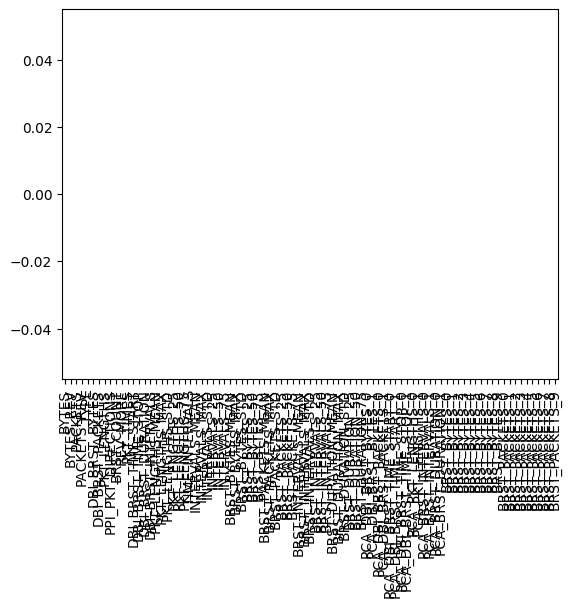

In [6]:
df.isnull().sum().plot(kind="bar")

We can see there are no null values in the data (as we will assume because the data is network traffic capture).

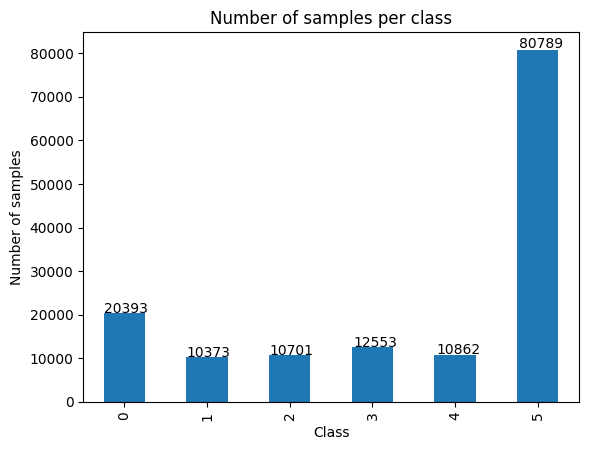

In [7]:
# Create the bar plot
ax = df.groupby(df["TYPE"]).size().plot(kind="bar", title="Number of samples per class", xlabel="Class", ylabel="Number of samples")

# Annotate each bar with the count
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

We see that there are a lot of samples for the fifth class, and a less significant number of samples for the other classes. In the process of building the model we will need to consider this imbalance in the data, if we will se bad results.

Basic split of the data to understand what the data can inform us on the network traffic type.

In [8]:
#split to x and y
X = df.drop(["TYPE"], axis=1)
Y = df["TYPE"]

filter to numeric data only (the other columns are categorical data, of the specific network traffic data per packet, we can extract the data from the other columns to reduce the dimensionality of the data)

In [9]:
# Filter X to keep only numeric columns
X_numeric = X.select_dtypes(include=['number'])
print("Filtered numeric data preview:")
X_numeric

Filtered numeric data preview:


,BYTES,BYTES_REV,PACKETS,PACKETS_REV,BRST_COUNT,REV_MORE,PKT_LENGTHS_MEAN,PKT_LENGTHS_MAX,PKT_LENGTHS_STD,PKT_LENGTHS_25,...,BRST_PACKETS_0,BRST_PACKETS_1,BRST_PACKETS_2,BRST_PACKETS_3,BRST_PACKETS_4,BRST_PACKETS_5,BRST_PACKETS_6,BRST_PACKETS_7,BRST_PACKETS_8,BRST_PACKETS_9
0,57363.0,12066294.0,1199.0,9548.0,1,1,1092.500000,1300,415.873278,1300.0,...,9543,0,0,0,0,0,0,0,0,0
1,779698.0,38492555.0,14539.0,28466.0,1,1,1143.300000,1368,439.354007,1368.0,...,28446,0,0,0,0,0,0,0,0,0
2,278099.0,43349394.0,4624.0,28939.0,8,1,1296.766667,1448,382.143314,1448.0,...,17863,2232,1087,2214,1107,2224,1096,1109,0,0
3,143766.0,16941036.0,2252.0,11364.0,15,1,1211.300000,1448,462.360404,1338.5,...,1205,599,598,592,623,569,592,600,591,597
4,1790845.0,115404196.0,37979.0,77255.0,15,1,1269.633333,1460,426.044480,1460.0,...,691,446,524,537,511,522,552,461,509,537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145666,160.0,224.0,4.0,5.0,1,1,42.666667,64,7.542472,40.0,...,5,0,0,0,0,0,0,0,0,0
145667,12443.0,101681.0,267.0,266.0,13,1,140.166667,914,188.342610,40.0,...,3,96,15,7,6,15,5,4,8,7
145668,133271.0,882577.0,1053.0,1064.0,15,1,540.433333,1460,656.805130,40.0,...,22,44,17,15,34,18,17,15,17,17
145669,1153975.0,84044865.0,23406.0,93051.0,6,1,469.533333,1460,611.155830,40.0,...,25933,903,1070,967,963,63051,0,0,0,0


## Feature Engineering Approach

Network traffic classification requires careful feature selection because not all traffic attributes are equally important for distinguishing between applications.

Our feature engineering process focuses on:

1. **Dimensionality Reduction**: Traffic data contains many features, some of which may be redundant or irrelevant. Reducing dimensionality helps improve model performance and interpretability.

2. **Time-Series Characteristics**: Network flows are fundamentally time-series data. Features that capture timing patterns (like variance in inter-arrival times) are particularly valuable for classification.

3. **Statistical Aggregations**: Individual packets are too granular for effective classification. Statistical aggregations (means, variances, percentiles) effectively capture the distribution of packet properties.


The engineered features will help our models distinguish between different application types even when the actual content of the packets remains hidden due to encryption.

### Dimensionality Reduction
First we want to understand the correlation between the features, to understand if there is dependency between the features. If there is dependency we can reduce the dimensionality of the data. To determine if there is dependency we will use PCA.


In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Determine the number of components needed to reach 95% of the variance
threshold = 0.95

# Assume X_numeric contains only numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Apply PCA keeping all components (based on numeric columns)
pca = PCA(n_components=X_numeric.shape[1])
pca.fit(X_scaled)

# Calculate cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative explained variance ratio per component:")
print(cumulative_variance)

Cumulative explained variance ratio per component:
[0.22243033 0.33350727 0.41212342 0.48067638 0.53888129 0.57994303
 0.61733106 0.64866788 0.67540917 0.70178546 0.72715507 0.75136501
 0.77525058 0.79752896 0.81910132 0.83833639 0.8549782  0.87148125
 0.88752666 0.9028386  0.91750407 0.93025249 0.94141905 0.95149676
 0.96032875 0.96721553 0.97383097 0.97954194 0.98333068 0.98655804
 0.98960504 0.99172321 0.99332356 0.99475477 0.99572349 0.99643165
 0.99711673 0.99771698 0.99821464 0.99864423 0.99889016 0.99910945
 0.99928057 0.99944954 0.99953106 0.99961161 0.99969145 0.99974738
 0.99978675 0.99981755 0.99984538 0.99987103 0.99989169 0.99990892
 0.99992539 0.99993972 0.9999528  0.9999646  0.99997517 0.99998216
 0.99998574 0.99998921 0.99999206 0.9999945  0.99999598 0.99999719
 0.99999815 0.99999885 0.99999943 0.99999985 0.99999996 0.99999999
 1.         1.         1.         1.        ]


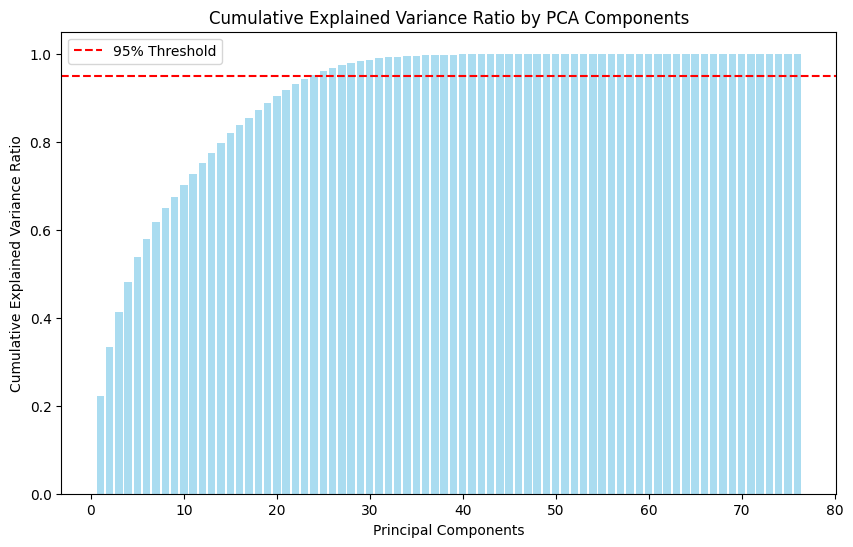

Number of components needed to explain 95% of variance: 24


In [11]:
# Plot cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(np.arange(1, len(cumulative_variance) + 1),
        cumulative_variance, alpha=0.7, color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by PCA Components')
plt.axhline(y=threshold, color='red', linestyle='--', label=f'{threshold*100:.0f}% Threshold')
plt.legend()
plt.show()


n_components_needed = np.argmax(cumulative_variance >= threshold) + 1
print("Number of components needed to explain",
      f"{threshold*100:.0f}% of variance:", n_components_needed)

We can see that there is dependency of the features, so we can use `SelectKBest` from `sklearn` to identify reduce the dimensionality of the data.

In [12]:
# Transform the scaled numeric data with the fitted PCA to get all components
X_pca = pca.transform(X_scaled)

# Extract only the first n_components_needed columns (principal components)
X_pca_selected = X_pca[:, :n_components_needed]

# Create a DataFrame with the selected PCA data using the mapped original column names
df_pca_original = pd.DataFrame(X_pca_selected)

print("Preview of the extracted PCA data with original column names:")
df_pca_original

Preview of the extracted PCA data with original column names:


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.607054,0.557197,-1.161833,-1.329516,1.570734,0.207903,-0.091550,0.373035,0.018203,0.201216,...,-0.082051,0.118983,0.536044,0.544001,-0.985491,-0.640737,0.492941,-0.179840,0.291037,-0.070724
1,2.537830,0.205753,-1.603480,-1.564017,1.335098,0.335180,0.481678,0.208618,-0.098447,-0.000288,...,-0.032659,0.150127,0.652185,0.587562,-1.044287,-0.723520,0.541553,-0.075024,0.489147,0.182867
2,1.118611,2.916428,-0.232196,-0.704439,1.212273,0.141429,-0.140557,1.085950,0.124138,0.429804,...,-0.182670,-0.229439,0.536571,0.674690,-0.220942,-0.314060,0.796200,0.225411,-0.274381,-0.628348
3,0.168485,2.787476,-1.140099,-1.460503,1.047879,0.204678,-0.696794,0.317227,-0.056769,-0.144649,...,-0.398353,0.018605,0.874219,-0.269258,-0.126033,-0.873927,0.066273,0.306940,0.080608,0.614364
4,0.693091,2.916567,-1.113632,-1.621036,1.187267,0.196248,-1.029540,0.415622,-0.202162,-0.239635,...,0.206402,-0.025519,0.542813,-0.349646,0.257644,-0.280425,-0.121106,0.361786,0.155754,0.474326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145666,-1.230348,-2.134984,1.397159,0.392724,-0.920288,1.140517,-0.086188,-0.058280,0.231768,0.183470,...,0.008794,-0.036026,0.221842,-0.214685,0.131730,0.004474,-0.045303,-0.000912,0.133994,0.376973
145667,-0.646554,-0.121943,0.488334,0.490829,-0.520826,0.416315,0.263801,-0.580594,0.382763,-0.254834,...,-0.880249,-0.449991,-0.884304,-1.456537,1.478955,-0.440400,-0.713035,-0.976916,-0.272514,0.729467
145668,-0.527492,0.675640,-0.673517,-0.672463,0.968166,-0.028926,-0.306263,0.248485,0.695579,0.375674,...,-1.549319,-0.276616,-0.690393,-0.373877,0.838936,0.496423,-0.359848,0.285740,-0.177362,1.285415
145669,6.043985,13.069944,11.653531,0.603233,-5.662326,-0.098309,7.753189,5.476597,3.761424,4.386245,...,-1.293190,-7.791611,6.203604,17.926565,18.956992,-1.689342,9.127412,-7.723090,-5.609121,0.474474


In [13]:
print(df_pca_original.columns)

RangeIndex(start=0, stop=24, step=1)


In [14]:
X_pca

array([[ 6.07053910e-01,  5.57197105e-01, -1.16183255e+00, ...,
         6.03846563e-07, -1.86482498e-05, -7.71011509e-07],
       [ 2.53782975e+00,  2.05752551e-01, -1.60348008e+00, ...,
         3.61907359e-06, -2.55602906e-05, -1.51805861e-06],
       [ 1.11861067e+00,  2.91642758e+00, -2.32195583e-01, ...,
         4.05133050e-05,  6.53044568e-05, -4.05596377e-05],
       ...,
       [-5.27491565e-01,  6.75639722e-01, -6.73517392e-01, ...,
        -1.24069629e-04,  1.73424319e-05,  8.89858832e-07],
       [ 6.04398468e+00,  1.30699441e+01,  1.16535312e+01, ...,
        -2.04385864e-02,  5.03761209e-04,  3.02548747e-03],
       [-7.59986479e-01,  2.49499448e+00, -2.77185033e+00, ...,
        -1.17641992e-04, -3.17340216e-04, -1.02289553e-05]])

### Feature Selection

In [15]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Long Runtime Cells ⏳

This cell has been commented out due to its long runtime. If you want to see the complete calculations, you will need to uncomment this cell and run it.

To uncomment the cell, simply remove the `#` or `"""` symbols at the beginning and end of the cells.

Please be aware that uncommenting and running this cell may take a significant amount of time, depending on the complexity of the calculations and the performance of your system 🖥️.

In [16]:
# # Define range of k values to test
# k_range = range(1, (len(X_numeric.columns) + 1)//2)
# scores_mean = []
# scores_std = []

# # For each k, perform feature selection and evaluate with cross-validation
# for k in k_range:
#     # Select k best features
#     selector = SelectKBest(score_func=mutual_info_classif, k=k)
#     X_selected = selector.fit_transform(X_numeric, Y)

#     # Evaluate using Random Forest with cross-validation
#     clf = RandomForestClassifier(max_depth=10, random_state=RANDOM_SEED)
#     scores = cross_val_score(clf, X_selected, Y, cv=5, scoring='accuracy')

#     scores_mean.append(scores.mean())
#     scores_std.append(scores.std())



In [17]:
# Find the optimal k
# optimal_k = k_range[np.argmax(scores_mean)] #To full runtime, remove this commet
optimal_k = 36

# # Plot results
# plt.figure(figsize=(10, 6))
# plt.plot(k_range, scores_mean, 'b-', label='Mean CV Score')
# plt.fill_between(k_range,
#                  np.array(scores_mean) - np.array(scores_std),
#                  np.array(scores_mean) + np.array(scores_std),
#                  alpha=0.2)
# plt.xlabel('Number of Features Selected (k)')
# plt.ylabel('Cross-Validation Accuracy')
# plt.title('Feature Selection Performance vs Number of Features')
# plt.grid(True)
# plt.legend()

# # Find the optimal k
# optimal_k = k_range[np.argmax(scores_mean)]
# plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
# plt.legend()
# plt.show()

To reduce the number of features we will run the `SelectKBest` identify the optimal number of features to use in the model.
We will run it until half of the number of features in the data and pick the optimal number of features that give us the best results. in this case the optimal number of features is 36.

In [18]:
print(f"Optimal number of features: {optimal_k}")
# print(f"Best cross-validation score: {max(scores_mean):.4f}")

Optimal number of features: 36


In [19]:
feature_names = np.array(X_numeric.columns)

# Using mutual information for feature selection
k_best_mi = SelectKBest(score_func=mutual_info_classif, k=optimal_k)
X_kbest_mi = k_best_mi.fit_transform(X_numeric, Y)

# Create DataFrame with selected features (using mutual information classifier selection)
X_selected = pd.DataFrame(X_kbest_mi, columns=feature_names[k_best_mi.get_support()])
print(f"\nShape of selected features: {X_selected.shape}")
X_selected


Shape of selected features: (145671, 36)


,BYTES,BYTES_REV,PACKETS,PACKETS_REV,PKT_LENGTHS_MEAN,PKT_LENGTHS_MAX,PKT_LENGTHS_STD,PKT_LENGTHS_25,PKT_LENGTHS_50,PKT_LENGTHS_75,...,PCA_DBI_BRST_PACKETS_1,PCA_DBI_BRST_TIME_START_0,PCA_DBI_BRST_TIME_STOP_0,PCA_PKT_LENGTHS_0,PCA_PKT_LENGTHS_1,PCA_BRST_DURATION_0,PCA_BRST_DURATION_1,BRST_BYTES_0,BRST_BYTES_1,BRST_PACKETS_0
0,57363.0,12066294.0,1199.0,9548.0,1092.500000,1300.0,415.873278,1300.0,1300.0,1300.00,...,-0.002948,-0.064074,-0.065812,4.268334,1.059109,-0.350535,0.042377,11684362.0,0.0,9543.0
1,779698.0,38492555.0,14539.0,28466.0,1143.300000,1368.0,439.354007,1368.0,1368.0,1368.00,...,0.100339,-0.064072,-0.054751,4.754931,1.463868,-0.339278,-0.131733,37012315.0,0.0,28446.0
2,278099.0,43349394.0,4624.0,28939.0,1296.766667,1448.0,382.143314,1448.0,1448.0,1448.00,...,0.772058,0.001421,-0.001593,5.916514,0.031626,-0.220426,-0.042726,25835232.0,3228530.0,17863.0
3,143766.0,16941036.0,2252.0,11364.0,1211.300000,1448.0,462.360404,1338.5,1448.0,1448.00,...,-0.213915,0.087765,0.082880,5.314518,1.307584,-0.231986,0.123182,1719683.0,864661.0,1205.0
4,1790845.0,115404196.0,37979.0,77255.0,1269.633333,1460.0,426.044480,1460.0,1460.0,1460.00,...,-0.206994,0.069640,0.064562,5.731270,0.654670,-0.224270,0.125757,1003845.0,649254.0,691.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145666,160.0,224.0,4.0,5.0,42.666667,64.0,7.542472,40.0,40.0,40.00,...,-0.055065,-0.121832,-0.126917,-4.735962,0.317149,-0.354766,0.107806,4277.0,0.0,5.0
145667,12443.0,101681.0,267.0,266.0,140.166667,914.0,188.342610,40.0,52.0,128.25,...,-0.051976,0.664654,0.693341,-3.705923,-0.276540,3.812195,-0.337360,1095.0,38442.0,3.0
145668,133271.0,882577.0,1053.0,1064.0,540.433333,1460.0,656.805130,40.0,52.0,1460.00,...,-0.055926,0.061697,0.057708,-0.316884,-0.686646,-0.275938,-0.017864,27211.0,40883.0,22.0
145669,1153975.0,84044865.0,23406.0,93051.0,469.533333,1460.0,611.155830,40.0,52.0,1224.75,...,7.395888,0.133354,0.202511,-1.052144,-1.362891,8.657506,-6.172540,25798570.0,902241.0,25933.0


# Model Training

In this section, we will train different models to classify the network traffic type. We will use the following models:
- K-Nearest Neighbors (KNN)
- Logistic Regression
- Support Vector Machine (SVM)
- Random Forest
- XGBoost
- Neural Network
- Ensemble Model

We will evaluate the models using the accuracy score and the classification report, and determine the best model for the network traffic classification type.

## Model Selection Rationale

For network traffic classification, we'll evaluate several models with different strengths:

1. **K-Nearest Neighbors (KNN)**:
  - Instance-based learning that captures local patterns in traffic data
  - Requires no training time, making it useful for rapid prototyping
  - Intuitive approach that classifies based on similarity to known traffic samples
  - Can adapt to new traffic patterns without retraining
  - Performs well when traffic categories form clear clusters in feature space

2. **Logistic Regression**:
  - Provides a probabilistic framework for understanding classification confidence
  - Offers high interpretability with coefficients directly relating to feature importance
  - Computationally efficient for both training and inference
  - Serves as an excellent baseline model to compare against more complex approaches
  - Despite its simplicity, often competitive for well-engineered features in network classification

3. **Support Vector Machines (SVM)**:
  - Particularly effective in high-dimensional spaces like network traffic features
  - Can handle non-linear classification through kernel functions
  - Focuses on finding optimal decision boundaries between traffic classes
  - Memory efficient as it uses only a subset of training points (support vectors)
  - Has shown strong performance in previous network traffic studies.

4. **Random Forest**:
  - Well-suited for tabular data with mixed feature types
  - Naturally handles non-linear relationships
  - Provides feature importance metrics to improve interpretability
  - Robust to outliers, which are common in network traffic data

5. **XGBoost**:
  - Gradient boosting typically achieves state-of-the-art performance on tabular data
  - Efficiently handles imbalanced classes through weighting mechanisms
  - Regularization parameters help prevent overfitting
  - Optimized for both speed and performance

6. **Neural Networks**:
  - Can capture complex, non-linear patterns in the data
  - Effective at learning hierarchical representations
  - Adaptable architecture can be tailored to the specific problem
  - Successfully applied to traffic classification in recent research

7. **Ensemble Methods**:
  - Combines predictions from multiple models to improve overall performance
  - Reduces variance and bias compared to individual models
  - Can integrate the strengths of different classification approaches
  - Particularly valuable for network traffic where patterns may be detected differently by various algorithms
  - Voting and stacking approaches can leverage specialized models for different traffic categories

Each model offers different trade-offs between accuracy, training time, inference speed, and interpretability. We'll compare them systematically to determine which is most suitable for real-world network traffic classification applications. The inclusion of diverse modeling approaches—from tree-based methods to distance-based algorithms and neural networks—ensures we explore the full spectrum of possible solutions for this complex classification problem.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

x_train, x_test, y_train, y_test = train_test_split(X_selected, Y, test_size=0.3, random_state=RANDOM_SEED)
print(x_train.shape, x_test.shape)


(101969, 36) (43702, 36)


We want to ensure there is the approximate same amount of data samples in the train and test sets.

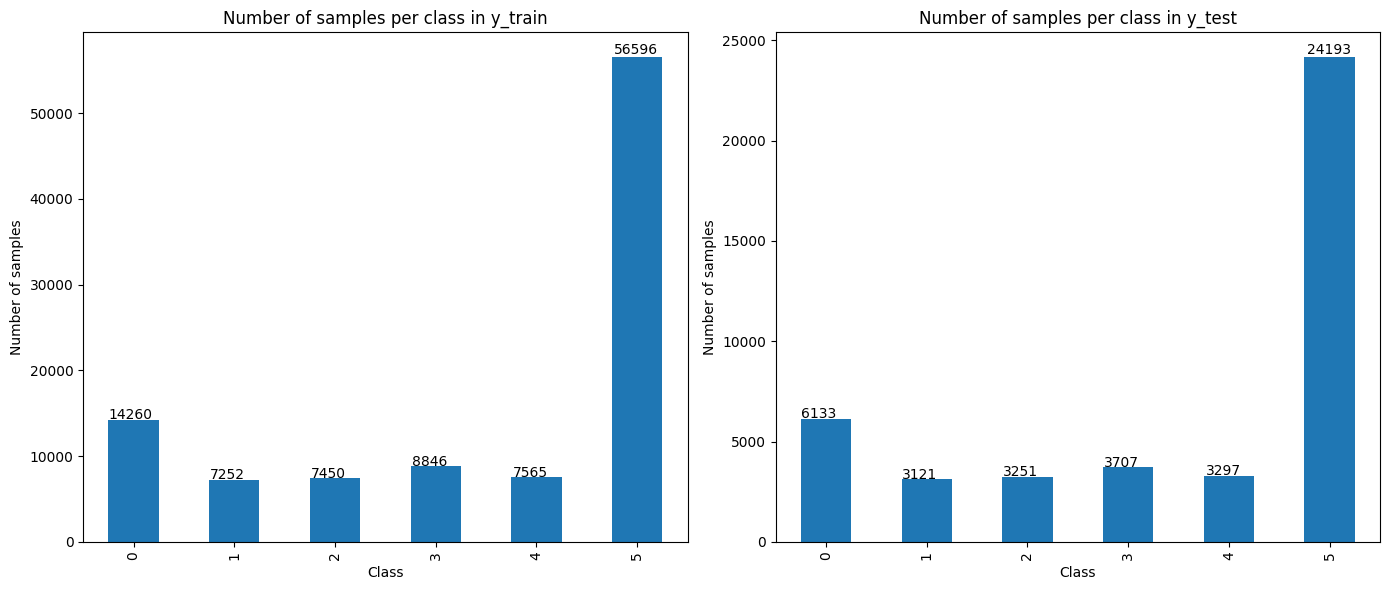

In [21]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for y_train
ax1 = y_train.value_counts().sort_index().plot(kind="bar", ax=axes[0], title="Number of samples per class in y_train", xlabel="Class", ylabel="Number of samples")
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Plot for y_test
ax2 = y_test.value_counts().sort_index().plot(kind="bar", ax=axes[1], title="Number of samples per class in y_test", xlabel="Class", ylabel="Number of samples")
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.tight_layout()
plt.show()

We see that the data distribution is approximately the same in the train and test sets.

## KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Normalize the features
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)

# Plot the accuracy for different values of k
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_norm, y_train)
    knn_pred = knn.predict(x_test_norm)
    accuracies.append(accuracy_score(y_test, knn_pred))

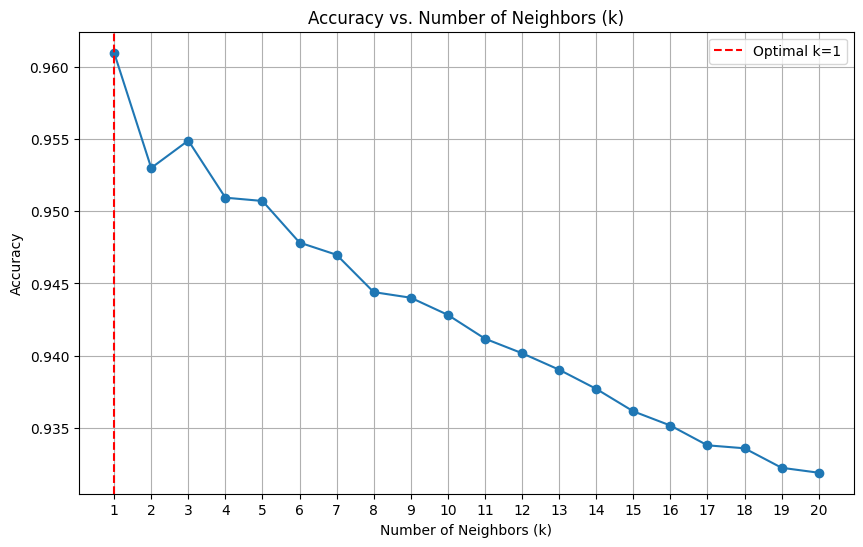

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors (k)')
plt.xticks(k_values)  # Set x-axis ticks to integer values
plt.grid(True)

# Find the optimal k
optimal_k = k_values[np.argmax(accuracies)]
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
plt.legend()
plt.show()

We can see that the optimal number of neighbors is 1. We will check the results to verify the model is not overfitting to the data.

In [24]:
# Find the max accuracy and corresponding K neighbors
max_accuracy = max(accuracies)
best_K = accuracies.index(max_accuracy) + 1

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=best_K)  # can adjust the number of neighbors
knn.fit(x_train_norm, y_train)

# Evaluate the model
knn_pred = knn.predict(x_test_norm)
knn_score = accuracy_score(y_test, knn_pred)
knnn_report = classification_report(y_test, knn_pred)

print("Accuracy:", knn_score)
print("Classification Report:")
print(knnn_report)

Accuracy: 0.9609857672417739
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6133
           1       0.91      0.91      0.91      3121
           2       0.87      0.88      0.88      3251
           3       0.93      0.93      0.93      3707
           4       0.98      0.96      0.97      3297
           5       1.00      1.00      1.00     24193

    accuracy                           0.96     43702
   macro avg       0.93      0.93      0.93     43702
weighted avg       0.96      0.96      0.96     43702



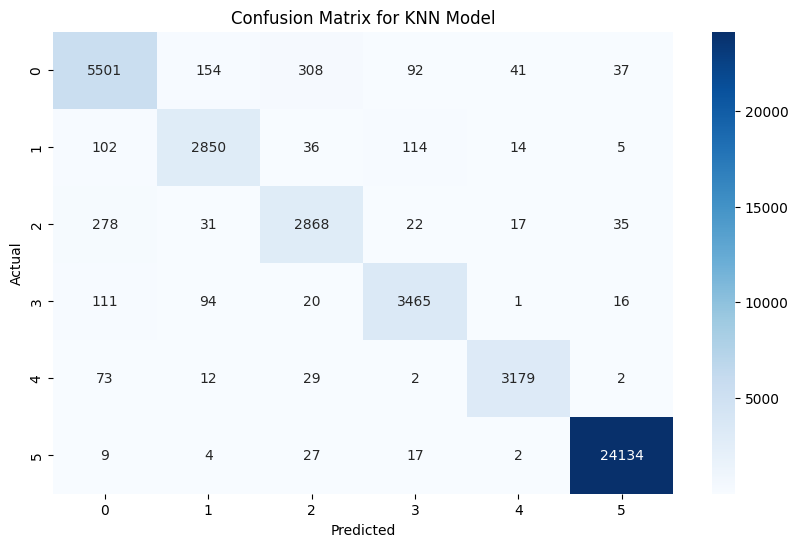

In [25]:
cm = confusion_matrix(y_test, knn_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for KNN Model')
plt.show()

We can see that there is a high accuracy score for the KNN model, and the confusion matrix shows that the model is not overfitting to the data. Moreover, we can see that there is some local patterns in the data due to the high accuracy score, and the nature of KNN with K=1.

## Logistic Regression

We will use the logistic regression model to classify the network traffic type. We will optimize the `max_iter` parameter to find the best accuracy score.

In [26]:
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)

# Long Runtime Cells ⏳

This cell has been commented out due to its long runtime. If you want to see the complete calculations, you will need to uncomment this cell and run it.

To uncomment the cell, simply remove the `#` or `"""` symbols at the beginning and end of the cells.

Please be aware that uncommenting and running this cell may take a significant amount of time, depending on the complexity of the calculations and the performance of your system 🖥️.

In [27]:
from sklearn.linear_model import LogisticRegression


# max_iter = 500
# # Initialize a list to store accuracy scores
# accuracy_scores = []

# # Loop through different max_iter values
# for i in range(1, max_iter):
#     lr = LogisticRegression(multi_class="multinomial", n_jobs=-1, random_state=RANDOM_SEED, max_iter=i)
#     lr.fit(x_train_norm, y_train)
#     lr_score = lr.score(x_test_norm, y_test)
#     accuracy_scores.append(lr_score)

In [28]:
# # Plot the accuracy scores
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, max_iter), accuracy_scores, label='Accuracy Score')
# plt.xlabel('Max Iterations')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs. Max Iterations for Logistic Regression')
# plt.legend()
# plt.grid(True)

# # Find the optimal max_iter
# optimal_iter = np.argmax(accuracy_scores) + 1
# plt.axvline(x=optimal_iter, color='r', linestyle='--', label=f'Optimal max_iter={optimal_iter}')
# plt.legend()
# plt.show()

# print(f"Optimal max_iter: {optimal_iter}")
# print(f"Best accuracy score: {max(accuracy_scores):.4f}")
# # Find the max accuracy and corresponding iteration
# max_accuracy = max(accuracy_scores)
# best_iter = accuracy_scores.index(max_accuracy) + 1
best_iter = 205

As we can see the optimal number of iteration is 205. We limited the number of iterations to 500, and we can see that the accuracy score is increasing with the number of iterations and then stay about the same. The limitation help us to keep the model from overfitting to the data.

In [29]:
# Train the model with the best iteration
lr = LogisticRegression(multi_class="multinomial", n_jobs=-1, random_state=RANDOM_SEED, max_iter=best_iter)
lr.fit(x_train_norm, y_train)
lr_score = lr.score(x_test_norm, y_test)
lr_pred = lr.predict(x_test_norm)
print("Classification report for test set")
print(classification_report(y_test, lr_pred))

Classification report for test set
              precision    recall  f1-score   support

           0       0.64      0.75      0.69      6133
           1       0.59      0.62      0.60      3121
           2       0.64      0.41      0.50      3251
           3       0.83      0.78      0.81      3707
           4       0.99      0.99      0.99      3297
           5       0.99      1.00      0.99     24193

    accuracy                           0.87     43702
   macro avg       0.78      0.76      0.76     43702
weighted avg       0.87      0.87      0.87     43702



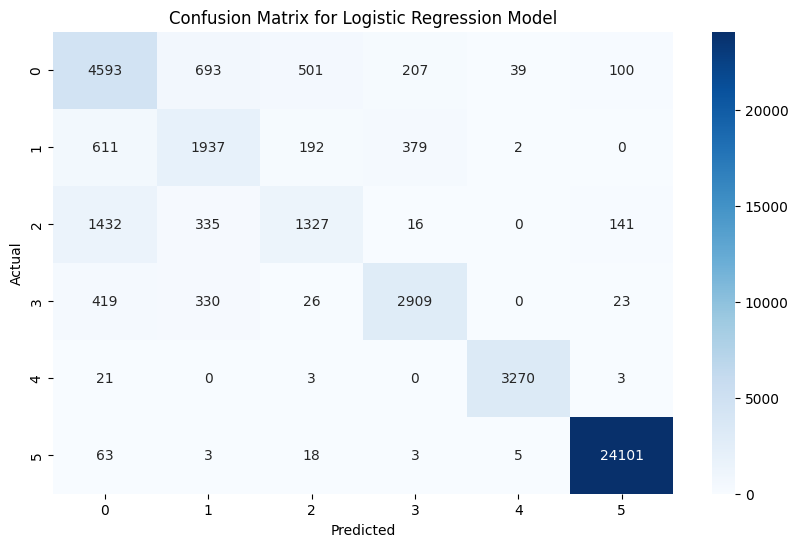

In [30]:
cm = confusion_matrix(y_test, lr_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

We see that we get low results for the logistic regression model, and the confusion matrix shows that the model is not overfitting to the data, that's can tell us that the data has no linear patterns, that cause this model to get low results compare to the other models.

## Support Vector Machine

In [31]:
from sklearn.svm import SVC

svc = SVC(random_state=RANDOM_SEED)
svc.fit(x_train_norm, y_train)
svc_score = svc.score(x_test_norm, y_test)
svc_pred = svc.predict(x_test_norm)
print("ACCURACY:", svc_score)
print("Classification report for test set")
print(classification_report(y_test, svc_pred))

ACCURACY: 0.899180815523317
Classification report for test set
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      6133
           1       0.66      0.75      0.70      3121
           2       0.81      0.39      0.53      3251
           3       0.87      0.89      0.88      3707
           4       1.00      0.98      0.99      3297
           5       0.99      1.00      0.99     24193

    accuracy                           0.90     43702
   macro avg       0.84      0.80      0.81     43702
weighted avg       0.90      0.90      0.89     43702



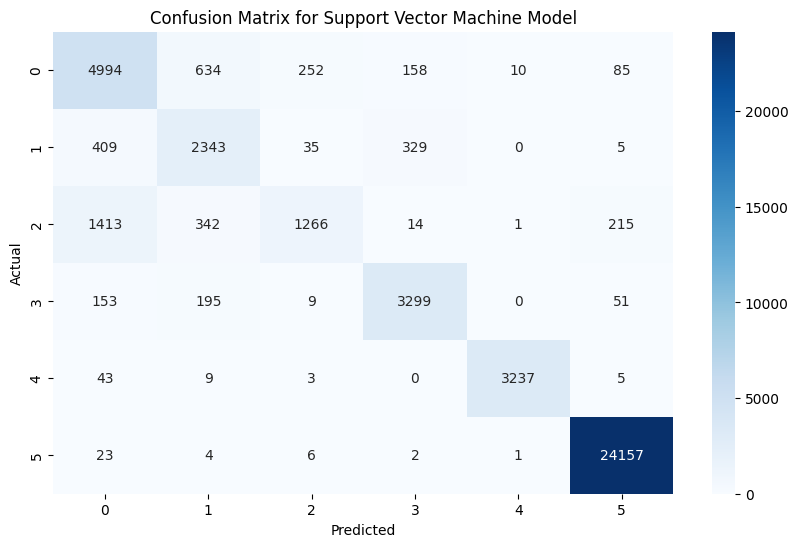

In [32]:
cm = confusion_matrix(y_test, svc_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Support Vector Machine Model')
plt.show()

We can see that the SVM model has also low results, and the confusion matrix shows that the model is not overfitting to the data, that's also can tell us that the data has no linear patterns, that cause this model to get low results compare to the other models.

## Random Forest

We will use the Random Forest model to classify the network traffic type. We will optimize the `max_depth` parameter to find the best accuracy score.

# Long Runtime Cells ⏳

This cell has been commented out due to its long runtime. If you want to see the complete calculations, you will need to uncomment this cell and run it.

To uncomment the cell, simply remove the `#` or `"""` symbols at the beginning and end of the cells.

Please be aware that uncommenting and running this cell may take a significant amount of time, depending on the complexity of the calculations and the performance of your system 🖥️.

In [33]:
# from sklearn.ensemble import RandomForestClassifier

# # Define the range of max_depth values to test
# max_depth_range = range(1, 40)
# mean_scores = []
# std_scores = []

# # Loop through each max_depth value
# for depth in max_depth_range:
#     rfc = RandomForestClassifier(max_depth=depth, n_jobs=-1, random_state=RANDOM_SEED)
#     scores = cross_val_score(rfc, x_train, y_train, cv=5, scoring='accuracy')
#     mean_scores.append(scores.mean())
#     std_scores.append(scores.std())

In [34]:
# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(max_depth_range, mean_scores, 'b-', label='Mean CV Score')
# plt.fill_between(max_depth_range,
#                  np.array(mean_scores) - np.array(std_scores),
#                  np.array(mean_scores) + np.array(std_scores),
#                  alpha=0.2)
# plt.xlabel('Max Depth')
# plt.ylabel('Cross-Validation Accuracy')
# plt.title('Random Forest Performance vs Max Depth')
# plt.grid(True)
# plt.legend()

# # Find the optimal max_depth
# optimal_depth = max_depth_range[np.argmax(mean_scores)]
# plt.axvline(x=optimal_depth, color='r', linestyle='--', label=f'Optimal max_depth={optimal_depth}')
# plt.legend()
# plt.show()


# print(f"Optimal max_depth: {optimal_depth}")
# print(f"Best cross-validation score: {max(mean_scores):.4f}")
optimal_depth=30

In [35]:
# Train the final model with the optimal max_depth
rfc = RandomForestClassifier(max_depth=optimal_depth, n_jobs=-1, random_state=RANDOM_SEED)
rfc.fit(x_train, y_train)
rfc_score = rfc.score(x_test, y_test)
rfc_pred = rfc.predict(x_test)
print("ACCURACY:", rfc_score)
print("Classification report for test set")
print(classification_report(y_test, rfc.predict(x_test)))

ACCURACY: 0.9919912132167864
Classification report for test set
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6133
           1       0.98      0.96      0.97      3121
           2       0.99      0.97      0.98      3251
           3       0.98      0.99      0.98      3707
           4       1.00      1.00      1.00      3297
           5       1.00      1.00      1.00     24193

    accuracy                           0.99     43702
   macro avg       0.99      0.98      0.99     43702
weighted avg       0.99      0.99      0.99     43702



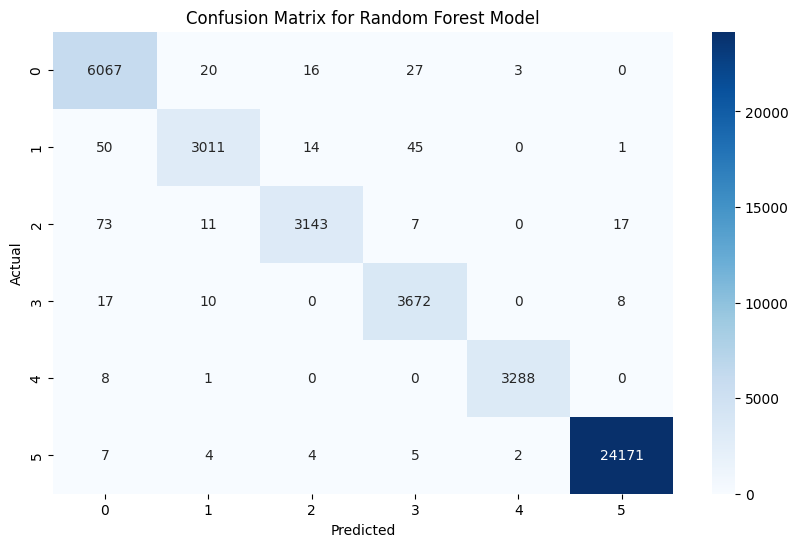

In [36]:
cm = confusion_matrix(y_test, rfc_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

Random forest get very high score as we see, that's due to the nature of Random forest that can handle well with tabular data and robust to outliers.

## XGBoost

In [37]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective="multi:softmax", n_estimators=300, max_depth=10)
xgb.fit(x_train, y_train)
xgb_score = xgb.score(x_test, y_test)
xgb_pred = xgb.predict(x_test)
print("ACCURACY:", xgb_score)
print("Classification report for test set")
print(classification_report(y_test, xgb_pred))

ACCURACY: 0.9962015468399615
Classification report for test set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6133
           1       0.99      0.98      0.99      3121
           2       0.99      0.98      0.99      3251
           3       0.99      1.00      0.99      3707
           4       1.00      1.00      1.00      3297
           5       1.00      1.00      1.00     24193

    accuracy                           1.00     43702
   macro avg       0.99      0.99      0.99     43702
weighted avg       1.00      1.00      1.00     43702



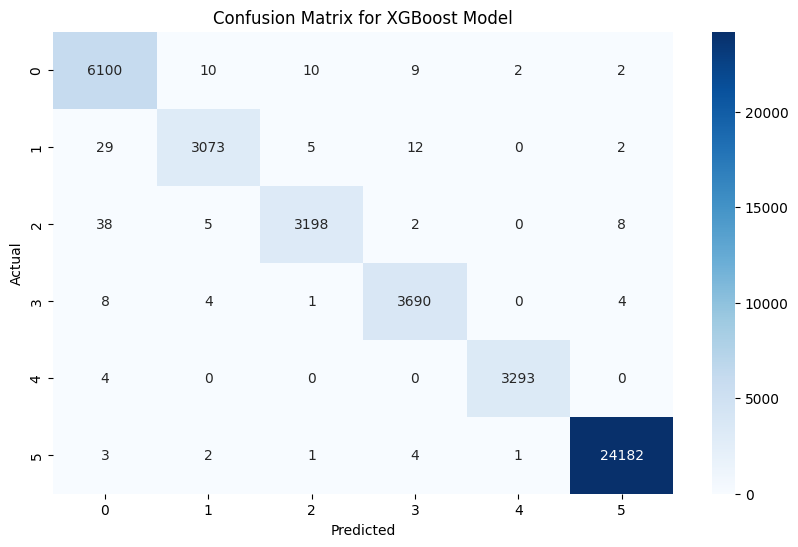

In [38]:
cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

XGBoost is the most powerful models for tabular data, and we see that he really get the highest score so far for the data, with score of 99.62% accuracy.

## Neural Network


In [39]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
tf.keras.utils.set_random_seed(RANDOM_SEED)

We will use the neural network model to classify the network traffic type. We will optimize the number of epochs to find the best accuracy score.

# Long Runtime Cells ⏳

This cell has been commented out due to its long runtime. If you want to see the complete calculations, you will need to uncomment this cell and run it.

To uncomment the cell, simply remove the `#` or `"""` symbols at the beginning and end of the cells.

Please be aware that uncommenting and running this cell may take a significant amount of time, depending on the complexity of the calculations and the performance of your system 🖥️.

In [40]:
# # Define the model
# def create_model():
#     model = Sequential([
#         Dense(256, activation='relu', input_shape=(x_train_norm.shape[1],)),
#         Dense(64, activation='relu'),
#         Dense(16, activation='relu'),
#         Dense(6, activation='softmax'),
#     ])
#     model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
#     return model


# # Variables to store results
# max_epoch = 50
# accuracies = []

# # Train the model for each epoch and store the accuracy
# for epoch in range(1, max_epoch + 1):
#     model = create_model()
#     history = model.fit(x_train_norm, y_train, validation_data=(x_test_norm, y_test), epochs=epoch, verbose=0)
#     accuracies.append(history.history['val_accuracy'][-1])

In [41]:
# # Plot the accuracies
# plt.plot(range(1, max_epoch + 1), accuracies)
# plt.xlabel('Epochs')
# plt.ylabel('Validation Accuracy')
# plt.title('Validation Accuracy vs. Epochs')
# plt.grid(True)

# # Find the optimal epoch
# best_epoch = np.argmax(accuracies) + 1
# plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Optimal epoch={best_epoch}')
# plt.legend()
# plt.show()

# print(f'Best epoch: {best_epoch}\n')
best_epoch = 47

We can see that the optimal number of epochs is 47, and we can see that the accuracy score is gets ups and downs but generally increasing with the number of epochs. The limitation helps us to keep the model from overfitting to the data, and preserve low runtime of the model.

In [42]:
nn = Sequential([
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(6, activation='softmax'),
])
nn.compile(loss="sparse_categorical_crossentropy",optimizer='adam', metrics=['accuracy'])
history = nn.fit(x_train_norm, y_train, validation_data=(x_test_norm, y_test), epochs=best_epoch)

Epoch 1/47
3187/3187 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8419 - loss: 0.4277 - val_accuracy: 0.8957 - val_loss: 0.2591
Epoch 2/47
3187/3187 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9097 - loss: 0.2313 - val_accuracy: 0.9142 - val_loss: 0.2211
Epoch 3/47
3187/3187 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9252 - loss: 0.1959 - val_accuracy: 0.9256 - val_loss: 0.1949
Epoch 4/47
3187/3187 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9333 - loss: 0.1772 - val_accuracy: 0.9281 - val_loss: 0.1880
Epoch 5/47
3187/3187 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9386 - loss: 0.1657 - val_accuracy: 0.9357 - val_loss: 0.1710
Epoch 6/47
3187/3187 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9419 - loss: 0.1567 - val_accuracy: 0.9366 - val_loss: 0.1686
Epoch 7/47
3187/3187 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9446 - loss: 0.1503 - val_accuracy: 0.9416 - val_loss: 0.1633
Epoch 8/47
3187/3187 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9465 - loss: 0.1440 - 

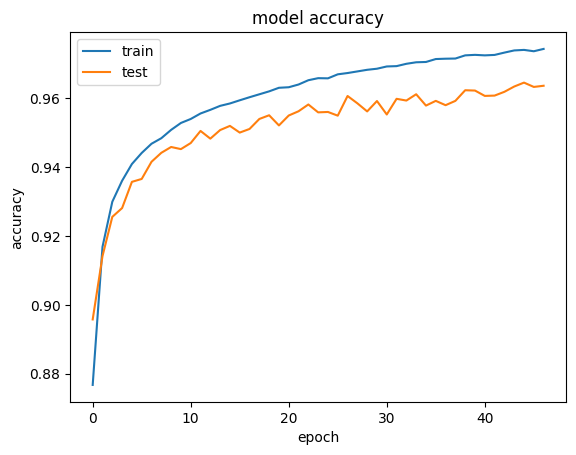

In [43]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We can see that the model accuracy un the test set is increasing with the number of epochs.

In [44]:
nn_pred = nn.predict(x_test_norm).argmax(-1)
nn_score = accuracy_score(y_test, nn_pred)
print("Accuracy:", nn_score)
print("Classification report for test set")
print(classification_report(y_test, nn_pred))

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Accuracy: 0.9636858725001144
Classification report for test set
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      6133
           1       0.93      0.94      0.93      3121
           2       0.89      0.83      0.86      3251
           3       0.92      0.96      0.94      3707
           4       1.00      0.99      0.99      3297
           5       1.00      0.99      1.00     24193

    accuracy                           0.96     43702
   macro avg       0.94      0.94      0.94     43702
weighted avg       0.96      0.96      0.96     43702



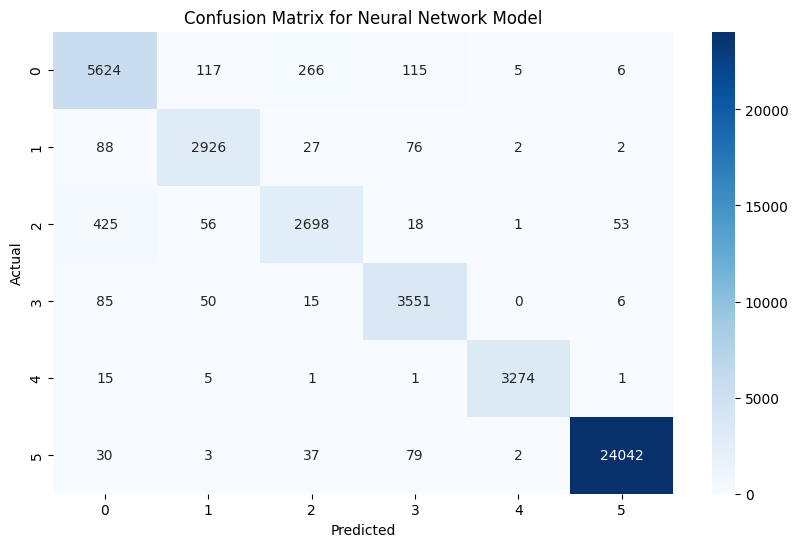

In [45]:
cm = confusion_matrix(y_test, nn_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Neural Network Model')
plt.show()

We see that neural notwork gets high score but not high as XGBoost and random forest, we assume that's because the neural network is less suitable for tabular data then random forest and XGBoost.

## Ensemble Learning Model

With such relative high accuracy scores for the models, we can try to combine the models to get better results. We will use the voting classifier and to combine the models.

In [46]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

# Define the neural network model function
def create_nn_model():
    nn = Sequential([
        Dense(256, activation='relu'),
        Dense(64, activation='relu'),
        Dense(16, activation='relu'),
        Dense(6, activation='softmax'),
    ])
    nn.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
    return nn

# Custom wrapper for Keras model
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, **kwargs):
        self.build_fn = build_fn
        self.kwargs = kwargs
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn(**self.kwargs)
        self.model.fit(X, y, **self.kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X).argmax(axis=-1)

    def predict_proba(self, X):
        return self.model.predict(X)

# Create the KerasClassifier wrapper for the neural network
nn_model = KerasClassifierWrapper(build_fn=create_nn_model, epochs=best_epoch, batch_size=32, verbose=0)

# Initialize individual models
lr = LogisticRegression(multi_class="multinomial", n_jobs=-1, random_state=RANDOM_SEED, max_iter=best_iter)
svc = SVC(random_state=RANDOM_SEED, probability=True)
rfc = RandomForestClassifier(max_depth=optimal_depth, n_jobs=-1, random_state=RANDOM_SEED)
xgb = XGBClassifier(objective="multi:softmax", n_estimators=300, max_depth=10, random_state=RANDOM_SEED)
knn = KNeighborsClassifier(n_neighbors=best_K)

# Create the voting classifier
voting_clf = VotingClassifier(estimators=[
    ('svc', svc),
    ('rfc', rfc),
    ('xgb', xgb),
    ('knn', knn),
    ('nn', nn_model)
], voting='soft')

# Train the voting classifier
voting_clf.fit(x_train_norm, y_train)

# Evaluate the voting classifier
voting_pred = voting_clf.predict(x_test_norm)
voting_score = accuracy_score(y_test, voting_pred)
voting_report = classification_report(y_test, voting_pred)

3187/3187 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8450 - loss: 0.4167
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [47]:
print("Ensemble Model Accuracy:", voting_score)
print("Classification Report for Ensemble Model:")
print(voting_report)

Ensemble Model Accuracy: 0.9853553613106951
Classification Report for Ensemble Model:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6133
           1       0.97      0.96      0.96      3121
           2       0.99      0.92      0.95      3251
           3       0.96      0.98      0.97      3707
           4       1.00      1.00      1.00      3297
           5       1.00      1.00      1.00     24193

    accuracy                           0.99     43702
   macro avg       0.98      0.97      0.97     43702
weighted avg       0.99      0.99      0.99     43702



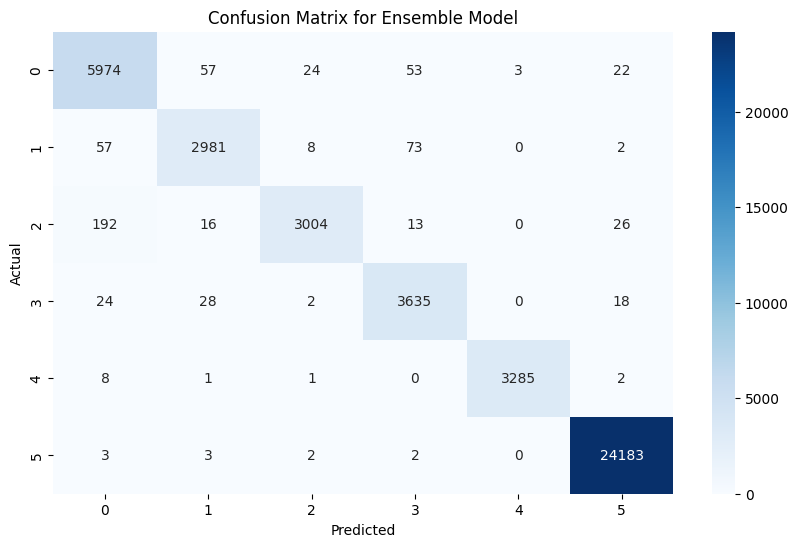

In [48]:
# Plot the confusion matrix for the ensemble model
cm = confusion_matrix(y_test, voting_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Ensemble Model')
plt.show()

AS we can see the ensemble model get high score from the neural network but still less than the XGBoost and Random forest models, that's maybe because all the models get wrong in the same samples.

## Summary

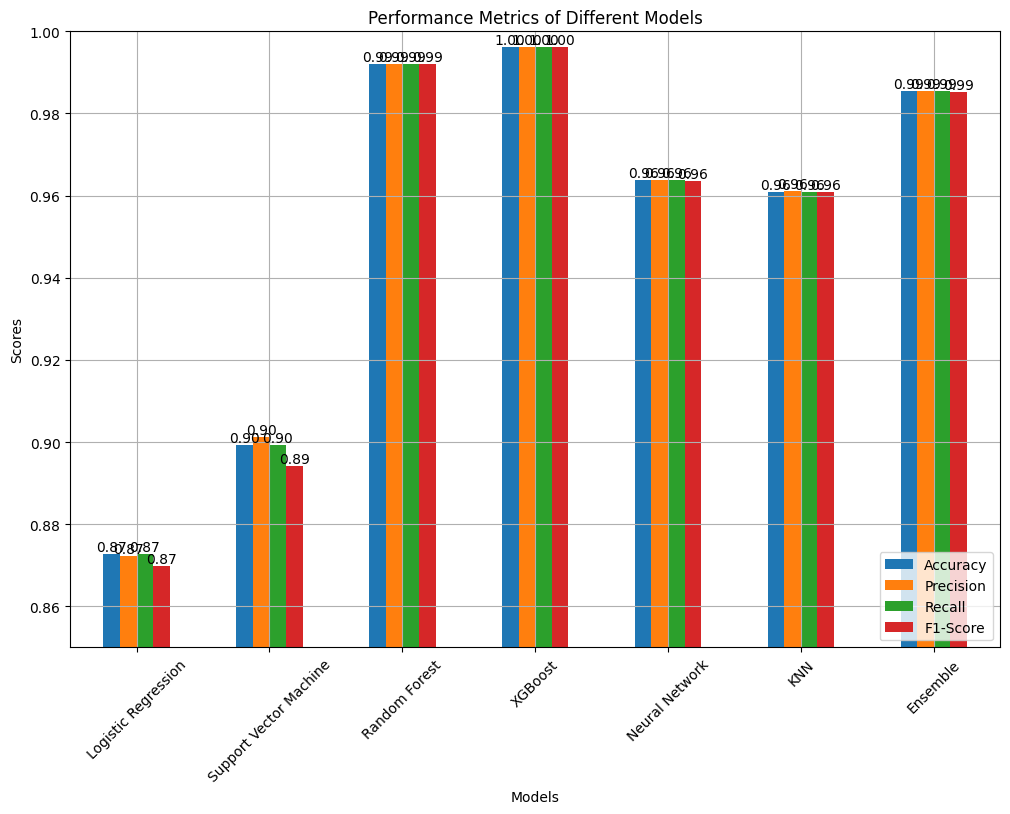

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to calculate metrics
def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Calculate metrics for each model
metrics = {
    "Logistic Regression": get_metrics(y_test, lr_pred),
    "Support Vector Machine": get_metrics(y_test, svc_pred),
    "Random Forest": get_metrics(y_test, rfc_pred),
    "XGBoost": get_metrics(y_test, xgb_pred),
    "Neural Network": get_metrics(y_test, nn_pred),
    "KNN": get_metrics(y_test, knn_pred),
    "Ensemble": get_metrics(y_test, voting_pred)
}

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame(metrics, index=["Accuracy", "Precision", "Recall", "F1-Score"])

# Plot the metrics
fig, ax = plt.subplots(figsize=(12, 8))
metrics_df.T.plot(kind='bar', ax=ax)
plt.title("Performance Metrics of Different Models")
plt.xlabel("Models")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(True)
ax.set_ylim(0.85, 1.0)  # Set the y-axis limit to start from 0.85


# Annotate each bar with the metric value
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()

In [50]:
# Function to calculate metrics
def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Calculate metrics for each model
metrics = {
    "Logistic Regression": get_metrics(y_test, lr_pred),
    "Support Vector Machine": get_metrics(y_test, svc_pred),
    "Random Forest": get_metrics(y_test, rfc_pred),
    "XGBoost": get_metrics(y_test, xgb_pred),
    "Neural Network": get_metrics(y_test, nn_pred),
    "KNN": get_metrics(y_test, knn_pred),
    "Ensemble": get_metrics(y_test, voting_pred)
}

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame(metrics, index=["Accuracy", "Precision", "Recall", "F1-Score"])

# Transpose the DataFrame
metrics_df_transposed = metrics_df.T
metrics_df_transposed

,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.872660,0.872131,0.872660,0.869809
Support Vector Machine,0.899181,0.901217,0.899181,0.894072
Random Forest,0.991991,0.992027,0.991991,0.991981
XGBoost,0.996202,0.996210,0.996202,0.996200
Neural Network,0.963686,0.963745,0.963686,0.963603
KNN,0.960986,0.961006,0.960986,0.960987
Ensemble,0.985355,0.985462,0.985355,0.985306


We can see that the most accurate model to classify a Network transport type is the XGBoost model that gain close to 100% accuracy and also Random. Forest model that gain 99% accuracy and in third place the ensemble model with 98.59%. more over we can see that SVM and logistic regression models get low results with a significant gat between them and the other models, we assume because the other models can identify non-linear relations in the data.

## From Model to Practical Application

This traffic classification model has several practical applications in network management:

**Security Monitoring:**
Unexpected traffic patterns can indicate potential security issues. For example, if a device that normally only generates web browsing traffic suddenly shows patterns matching file transfer or remote access, this could indicate compromised security.

**Capacity Planning:**
Understanding the composition of network traffic helps administrators plan infrastructure upgrades based on actual usage patterns and trends.

**Policy Enforcement:**
Classification enables the enforcement of acceptable use policies by identifying applications that might be prohibited on corporate networks.


## Conclusion and Future Work

This project demonstrates the effectiveness of machine learning for network traffic classification using flow-level statistics. Our XGBOOST model achieved strong performance across different traffic types, with an overall accuracy of approximately 99.62%.

The ability to classify encrypted traffic without deep packet inspection represents a significant advantage for modern networks where privacy concerns and encryption are increasingly important.

**Key learnings:**
- Flow-level statistics contain rich information about application behavior
- Ensemble methods like Random Forest and XGBoost are well-suited to this classification task
- Feature importance analysis reveals the network characteristics that best distinguish different applications

**Future improvements could include:**
- Incorporating temporal features to detect changes in behavior over time
- Expanding the dataset to include more diverse network conditions and applications
- Exploring deep learning approaches for capturing sequential patterns in traffic
- Developing an online learning system that can adapt to evolving traffic patterns

By continuing to refine these methods, we can build more intelligent networks that automatically optimize themselves based on the types of traffic they carry.